# Numerical Integration of a Toda Lattice

In [7]:
%matplotlib notebook
from matplotlib.pyplot import *
from rk4 import *
import numpy as np

## Physical Model

In short, the Toda Lattice equation is a N-oscillator chain nonlinear chain whose dynamics is described by
$$m\ddot{x}=A\left\{ \exp\left[-v\left(x_{i-1}-x_{i}\right)\right]-\exp\left[-v\left(x_{i}-x_{i+1}\right)\right]\right\}
$$.

In the small amplitude regime, i.e. $x_i-x_{i+1}\approx \Delta + \delta_i$, it can be shown that the linear oscillator chain is recovered as 
$$m\ddot{x}=A\left\{ \exp\left[-k\left(x_{i-1}-x_{i}\right)\right]-\exp\left[-k\left(x_{i}-x_{i+1}\right)\right]\right\}
$$

In [13]:
####Function to be integrated####
#################################
def todachain(v,n_osc,tinit,tstop,dt,initial_condition):
    
    def F(t,y):
        Fi=np.zeros(n_osc*2)
        for i in range(0,n_osc*2,2):
            Fi[i]=y[i+1]
            
            if i==n_osc*2-2:
                Fi[i+1]=(-np.exp(-v*(y[0]-y[i]))+np.exp(-v*(y[i]-y[i-2])))
            else:
                Fi[i+1]=(-np.exp(-v*(y[i+2]-y[i]))+np.exp(-v*(y[i]-y[i-2])))
             
        return Fi
            
    T,Y=integrate(F,0,initial_condition,tstop,dt)
    positions=np.zeros((len(T),n_osc))
    for i in range(0,len(T)):
        for j in range(0,n_osc):
            positions[i,j]=Y[i,2*j]
    return T,Y,positions

## Simulating a Toda Lattice

<IPython.core.display.Javascript object>


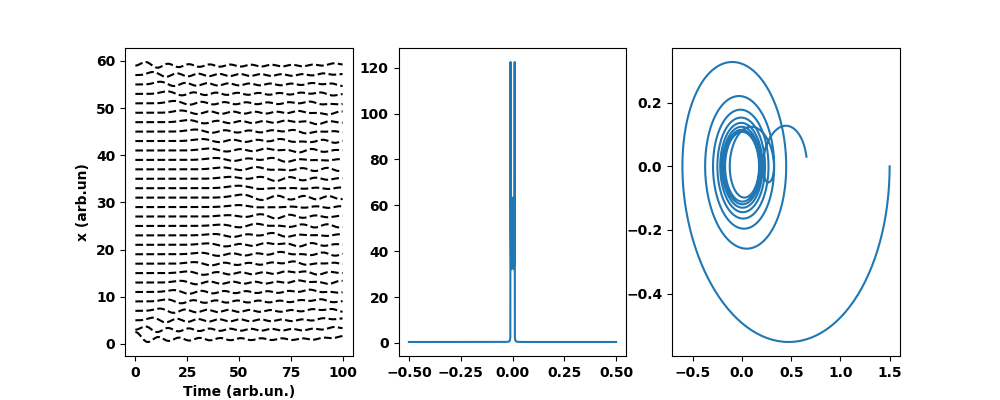

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


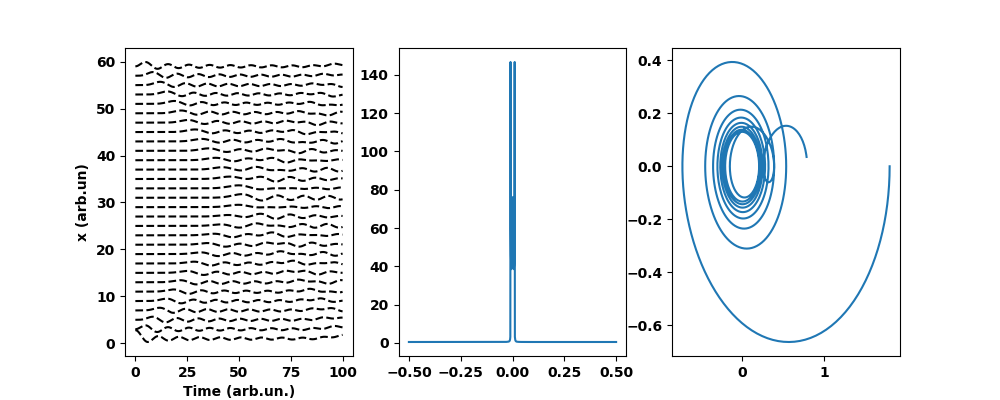

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [95]:

####
n_oscillators=30

#encoding amplitude
A = 1.5

#initial distance between consecutive oscillators
delta=2

#integration parameters
tinit=0
tstop=100
dt=0.1

#nonlinearity strength
v=-0.1

def encoding(n_osc,features,A,delta):    
    y=np.zeros(n_osc*2)
    for i in range(0,n_osc*2,2):
        if i == 0:
            y[0] = A
        else:
            y[i] = 0
    return y

####example results
fig, ax = subplots(1,3,figsize=[10,4])

initial_condition = encoding(n_oscillators,features, A, delta)
T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
for j in range(0,n_oscillators):
    ax[0].plot(T,positions[:,j]+(j*delta+delta/2),'--',color='k')
ax[0].set_xlabel('Time (arb.un.)')
ax[0].set_ylabel('x (arb.un)')

ax[1].plot(fft.fftshift(fft.fftfreq(len(positions[:,0]))),
           fft.fftshift(fft.fft(positions[:,0])))

ax[2].plot(Y[:,0],Y[:,1])

fig, ax = subplots(1,3,figsize=[10,4])

A = 1.8
v=-0.1
initial_condition = encoding(n_oscillators,features, A, delta)
T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
for j in range(0,n_oscillators):
    ax[0].plot(T,positions[:,j]+(j*delta+delta/2),'--',color='k')
ax[0].set_xlabel('Time (arb.un.)')
ax[0].set_ylabel('x (arb.un)')
ax[1].plot(fft.fftshift(fft.fftfreq(len(positions[:,0]))),
           fft.fftshift(fft.fft(positions[:,0])))

ax[2].plot(Y[:,0],Y[:,1])

<IPython.core.display.Javascript object>


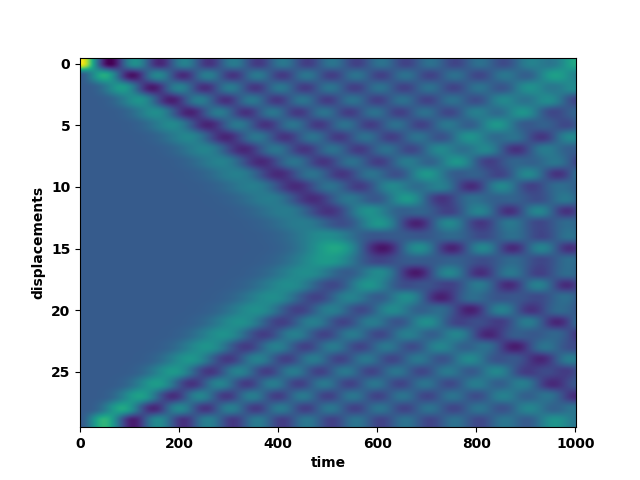

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 30, using nperseg = 30
  .format(nperseg, input_length))


<IPython.core.display.Javascript object>


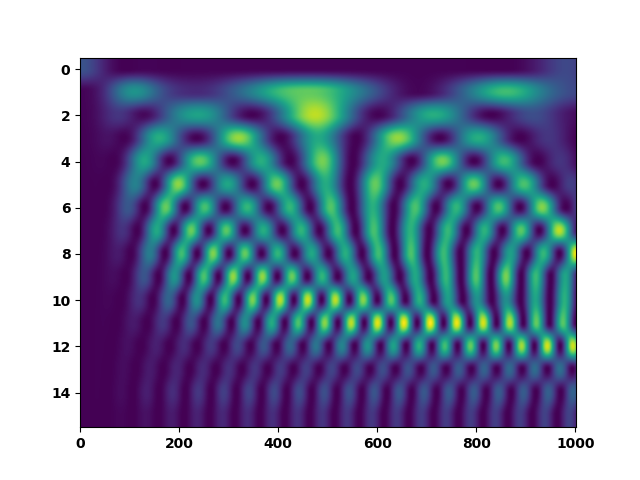

In [96]:
from scipy import signal
subplots()
imshow(np.transpose(Y[:,::2]),aspect='auto')
xlabel('time')
ylabel('displacements')

f,t, spec = signal.spectrogram(Y[:,::2], fs=1.0, window=('tukey', 0.25), 
                nperseg=None, noverlap=None, nfft=None, detrend='constant', 
                        return_onesided=True, scaling='density', axis=- 1, mode='psd')

subplots()
imshow(np.transpose(spec[:,:,0]),aspect='auto')

## Building a "Physical" Extreme Learning Machine

An Extreme Learning Machine leverages on the projection of each element I of the input space $$X^{(I)} = \left(\begin{array}{c}
x^{(I)}_{1}\\
...\\
x^{(I)}_{N_{features}}
\end{array}\right)$$ onto an high-dimensional output space 
$$
\boldsymbol{Y}\left(\boldsymbol{X}^{(I)}\right)=\left(\begin{array}{c}
G_{1}\left(w_{i}x_{i}^{(I)}+b_{i}\right)\\
G_{2}\left(w_{i}x_{i}^{(I)}+b_{i}\right)\\
...\\
G_{N_{c}}\left(w_{i}x_{i}^{(I)}+b_{i}\right)
\end{array}\right)
$$
with G the activiation function, w the weights and b the bias. 

In our physical implementation we will encode each feature in the initial displacement of the oscillator N and obtain the output information Y at the end of the simulation, defined by the $$t_{stop}$$.

In [73]:
def encoding(n_osc,features,A):
    
    y=np.zeros(n_osc*2)
    for i in range(0,n_osc*2,2):
        if i < len(features)*2:
            y[i]=A*features[int(i%2)]
        else:
            y[i]=0

    return y

####example results


A = 1.0
v=-0.5


#integration parameters
tinit=0
tstop=50
dt=0.1


npoints=64
x_train = [i for i in range(0,npoints,2)]
x_test = [i+1 for i in range(0,npoints,2)]


output_train_store=[]
for i in range(0,len(x_train)):
    print(str(i),end='\n')
    features = [x_train[i]/npoints+0.5]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_train_store.append(positions[-1,:])
    
output_test_store=[]
for i in range(0,len(x_test)):
    print(str(i),end='\n')
    features = [x_test[i]/npoints+0.5]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_test_store.append(positions[-1,:])
    
    

0
1


2


3


4
5


6


7


8


9
10


11


12


13


14


15


16
17


18


19


20


21
22


23


24


25


26
27


28


29


30


31
0


1


2
3


4


5


6


7
8


9


10


11
12


13


14


15
16


17


18


19
20


21


22
23


24


25


26
27


28


29


30
31


## Training 

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: scipy.sinc is deprecated and will be removed in SciPy 2.0.0, use numpy.sinc instead
  """
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead
  


<IPython.core.display.Javascript object>


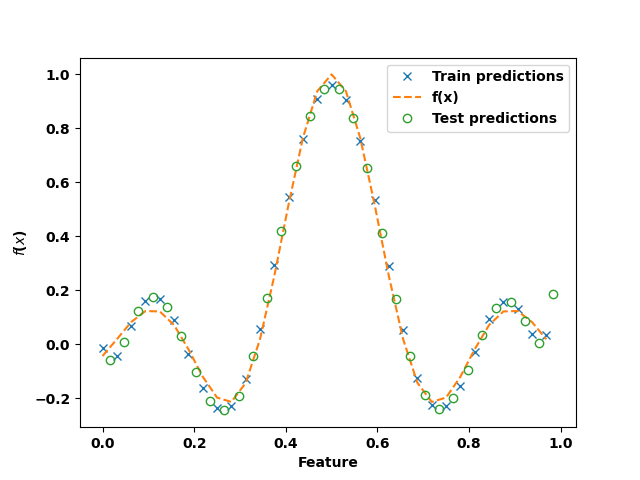

In [75]:
T_store=[]

#construct the function to train a regression
for number_x in range(0,npoints,2):
    T_store.append(sinc(pi*(number_x/float(npoints/2)-1)))

pseudo_inv=np.linalg.pinv(output_train_store)
W_out=dot(pseudo_inv,T_store)
train_data=np.dot(output_train_store, W_out)
test_data=np.dot(output_test_store, W_out)

subplots()
plot(np.array(x_train)/npoints,train_data,'x',label='Train predictions')
plot(np.array(x_train)/npoints,T_store,'--',label='f(x)')
plot(np.array(x_test)/npoints,test_data,'o',fillstyle='none',label='Test predictions')
xlabel('Feature')
ylabel('$f(x)$')
legend()